# What this is
I am using data science tools in order to analyze my financial decisions. Below I will be:
* Looking at data correlation;
* Cleaning the data to avoid empty and redundant information;
* Using LinearRegression and PolinomiaRegression to "predict" my average spending using index as parameter (not expecting good results, but as illustration for the next point);
* Using AutoRegression, commonly used for time series, and then also implementing it using LinearRegression for p = 1 (for illustrative purposes);

# Goals

Using my financial information, I want to:
* Understand my pattern of spending;
* Understand why I spent so little in general in the past, enough to be proud of my responsability with money, but now its been the opposite (this will be further demonstrated below);
* Make a personal analysis tool for myself that can help me avoid lifestyle creep;

# Reading Finances File

In [1]:
import pandas as pd
import plotly.figure_factory as ff
import numpy as np

In [3]:


file_path = "src/historic.xlsx"

# Load the "historic" sheet into a DataFrame
historic_df = pd.read_excel(file_path, )
# Remove completely empty rows and columns
historic_cleaned_df = historic_df.dropna(how='all').dropna(axis=1, how='all')

# Display the first few rows of the "historic" sheet to understand its structure
historic_cleaned_df.head()


,Positive Value,IFOOD TOTAL,Agua Serviço Gasto,WITH-OTHER-PEOPLE TOTAL,Extra Groceries 🥫 TOTAL,Final Maximum,Final Minimum,Rancho,TRANSPORTE TOTAL,Maximum Expense,Current,Minimum Expense,Beleza TOTAL
0,3020,46,44.45,386.7,56.57,464.23,600.91,0,164.46,2555.77,600.91,2419.09,301.59
1,3020,57,44.45,201.0,5.00,-314.77,109.09,0,105.14,3334.77,564.09,2910.91,300.00


In [5]:
# checking it loaded all months, by looking at water consumption column
historic_cleaned_df["Agua Serviço Gasto"]

0    44.45
1    44.45
Name: Agua Serviço Gasto, dtype: float64

In [6]:

# Function to convert all object columns to float where possible
def convert_objects_to_float(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # Check if the column is of type object
            try:
                # Attempt to convert the object column to float
                df[col] = pd.to_numeric(df[col], errors='ignore')
            except ValueError:
                # If conversion fails, leave the column as is
                pass
    return df

# Apply the conversion function to your DataFrame
historic_cleaned_df = convert_objects_to_float(historic_cleaned_df)

# Display the updated DataFrame with converted columns
print(historic_cleaned_df.dtypes)


Positive Value               int64
IFOOD TOTAL                  int64
Agua Serviço Gasto         float64
WITH-OTHER-PEOPLE TOTAL    float64
Extra Groceries 🥫 TOTAL    float64
Final Maximum              float64
Final Minimum              float64
Rancho                       int64
TRANSPORTE TOTAL           float64
Maximum Expense            float64
Current                    float64
Minimum Expense            float64
Beleza TOTAL               float64
dtype: object


In [7]:

historic_only_numerics = historic_cleaned_df.select_dtypes(include=['number'])
historic_only_numerics.head()

,Positive Value,IFOOD TOTAL,Agua Serviço Gasto,WITH-OTHER-PEOPLE TOTAL,Extra Groceries 🥫 TOTAL,Final Maximum,Final Minimum,Rancho,TRANSPORTE TOTAL,Maximum Expense,Current,Minimum Expense,Beleza TOTAL
0,3020,46,44.45,386.7,56.57,464.23,600.91,0,164.46,2555.77,600.91,2419.09,301.59
1,3020,57,44.45,201.0,5.00,-314.77,109.09,0,105.14,3334.77,564.09,2910.91,300.00


# Relevant Correlation


In [10]:

historic_useful_for_correlation = historic_only_numerics.drop([
      "Lazer Marginal", # Derived
      "Uber marginal", # Derived
      "Lazer Proporcional a Renda", # Derived
      "festive events", # Too little sample
      "Rancho Indiv.", # Derived
      "roommates", # Doesnt change
      "aluguel", # irrelevant
      "Trabalhos",
      "Pessoas",
      "Positive Value" # the only moment it changes is when rent changes
  ], axis=1,errors='ignore')
historic_useful_for_correlation = historic_useful_for_correlation.dropna(how="any")
historic_useful_for_correlation

,IFOOD TOTAL,Agua Serviço Gasto,WITH-OTHER-PEOPLE TOTAL,Extra Groceries 🥫 TOTAL,Final Maximum,Final Minimum,Rancho,TRANSPORTE TOTAL,Maximum Expense,Current,Minimum Expense,Beleza TOTAL
0,46,44.45,386.7,56.57,464.23,600.91,0,164.46,2555.77,600.91,2419.09,301.59
1,57,44.45,201.0,5.00,-314.77,109.09,0,105.14,3334.77,564.09,2910.91,300.00


In [11]:

corr = historic_useful_for_correlation.corr()
x = list(corr.columns)
y = list(corr.index)
z = np.array(corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.show()



In [12]:
variables_with_no_interesting_correlation = []
for column in corr.columns:
  correlations_for_column = []
  for row in corr.columns:
    if abs(corr[column][row]) > 0.5 and column != row:
      correlations_for_column.append(corr[column][row])
  if len(correlations_for_column) == 0:
    variables_with_no_interesting_correlation.append(column)

print("variables_with_no_interesting_correlation", variables_with_no_interesting_correlation)

variables_with_no_interesting_correlation ['Agua Serviço Gasto', 'Rancho']


Just because these variables didnt have any interesting correlation, doesnt mean they are not useful. On the contrary, too much correlation might cause redundancy, and considering these low correlation variables can allow for complex behaviour not previously thought of

# Controllable Variables

In here, I will be looking at the behaviour, through the months, of the costs that I have conscious and immediate control over.

To count as controllable variables, it must be:
* "Optional": assumes that I could be reducing or cutting them;
* "Consumable/Integrative": The overall result of the cost is a combination of several concious uses over the period of a month. I can spend as much as I so choose, and there is hardly a cap to how much that value is. Their only restriction is my willingness to spend money that month.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

controllable_variables = [
    "IFOOD TOTAL",
    "WITH-OTHER-PEOPLE TOTAL",
    "Extra Groceries 🥫 TOTAL",
    "TRANSPORTE TOTAL",
	"Beleza TOTAL" 
] 


In [18]:
historic_controllable = historic_useful_for_correlation[controllable_variables]
corr = historic_controllable.corr()
x = list(corr.columns)
y = list(corr.index)
z = np.array(corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.show()



average_controllable_spendings 811.73


[np.float64(955.3199999999999), np.float64(668.14)]

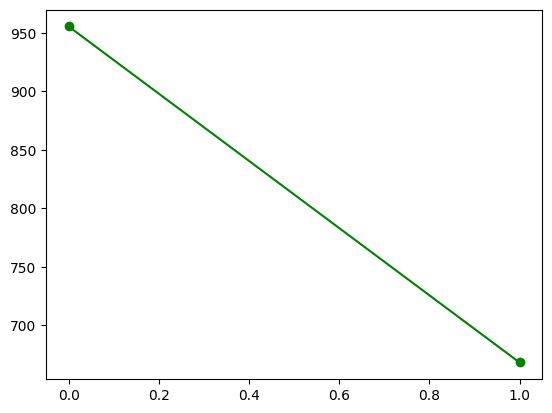

In [19]:
average_controllable_spendings = 0

for variable in controllable_variables:
  average_controllable_spendings += historic_useful_for_correlation[variable].mean()

print("average_controllable_spendings", average_controllable_spendings)

all_controllable_spendings_of_a_month = []
month_spending_color = []
for row in historic_useful_for_correlation.index:
  row_controllable_spendings = 0
  for variable in controllable_variables:
    row_controllable_spendings += historic_useful_for_correlation[variable][row]

  if row_controllable_spendings > average_controllable_spendings:
    color = "red"
  else:
    color = "green"
  if row_controllable_spendings == 0:
    continue
  month_spending_color.append(color)
  all_controllable_spendings_of_a_month.append(row_controllable_spendings)


# Plot the line using segments of different colors
fig, ax = plt.subplots()

for i in range(1, len(all_controllable_spendings_of_a_month)):
    ax.plot([i-1, i],
            [all_controllable_spendings_of_a_month[i-1], all_controllable_spendings_of_a_month[i]],
            marker='o',
            color=month_spending_color[i])
all_controllable_spendings_of_a_month

Reference Material For Regression: https://medium.com/@shuv.sdr/polynomial-regression-in-python-58198fb0973f

Reference Material for Time Series: https://www.timescale.com/blog/how-to-work-with-time-series-in-python/

I will be passing a single input for the regression, that will be the index of the data in the list. This has an implicit expectation that the data is "self explanatory", in the sense that its behaviour has some consistent linear relatonship with time. In a sense, what is defining the result of the regression are the values themselves.
This is somewhat similar to predicting stock! At least, considering the inputs. When predicting stocks, we have some expectation that the data has a self-correlation, a correlation with previous values.

Below the linear regression, I have used a time series model for the same purpose to compare results: AutoRegression.
And then, finally, I made the same model but manually using LinearRegression for p = 1, to demonstrate how it works.

It will, of course, not be highly efficient at prediction. Or at least, it is not expected to. After all, we dont actually believe there to be a pattern of self-correlation (but it might be interesting to check if there is, comparing results with the future "better model" that we will use).


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

twod_all_controllable_spendings_of_a_month = []
X = np.array([])
y = np.array([])
for i, value in enumerate(all_controllable_spendings_of_a_month):
  X = np.append(X,i)
  y = np.append(y,value)
  twod_all_controllable_spendings_of_a_month.append([i, value])

lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)


pr = PolynomialFeatures(degree = 3)
X_poly = pr.fit_transform(np.array(X).reshape(-1, 1))
lr_2 = LinearRegression()
lr_2.fit(X_poly, y)

LinearRegression()

prediction lr: 380.96000000000026


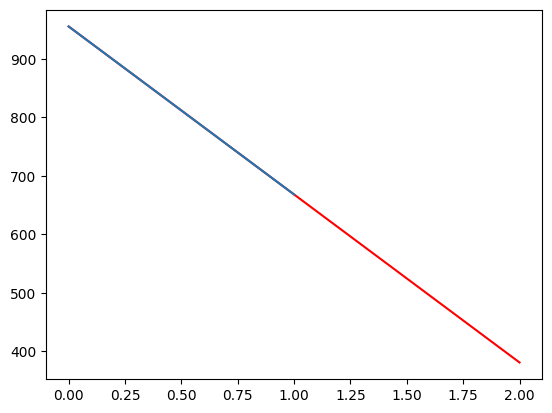

In [22]:

range_of_prediction =  [i for i in range(len(all_controllable_spendings_of_a_month) +1)]
reshaped_range = np.array(range_of_prediction).reshape(-1, 1)
y_pred_lr = lr.predict(reshaped_range)
# y_pred_pr = lr_2.predict(pr.fit_transform(reshaped_range))

sns.lineplot(x = [i for i in range(len(y_pred_lr))], y = y_pred_lr,
             color="red")

#sns.lineplot(x = [i for i in range(len(y_pred_pr))], y = y_pred_pr,color="yellow")
sns.lineplot(x = [i for i in range(len(all_controllable_spendings_of_a_month))], y = all_controllable_spendings_of_a_month)

print("prediction lr:",y_pred_lr[-1])

In [23]:
data = pd.DataFrame(all_controllable_spendings_of_a_month, columns=['y'])
#data['x'] = data.index
data

,y
0,955.32
1,668.14


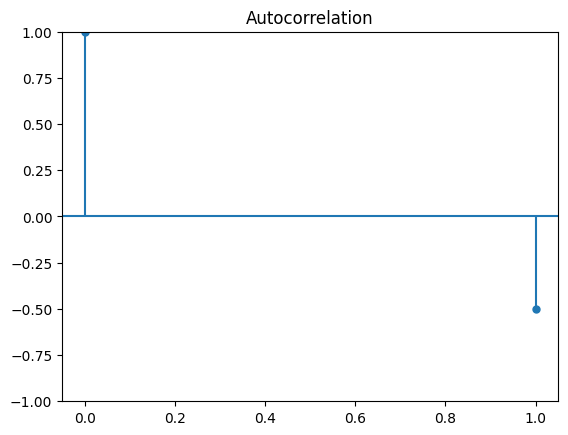

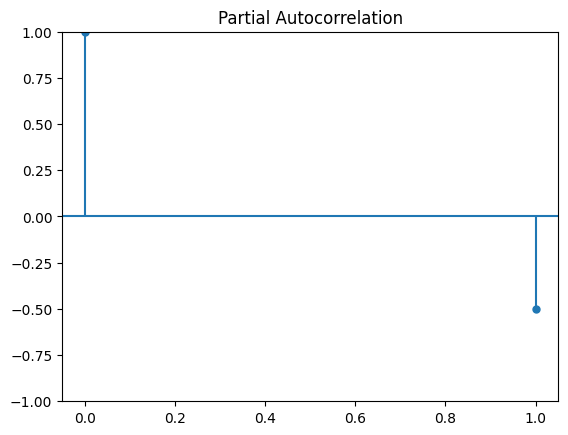

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'data' is the time series data
plot_acf(data)
plot_pacf(data)
plt.show()

In [27]:
from statsmodels.tsa.ar_model import AutoReg

n = 0
# AR
model = AutoReg(all_controllable_spendings_of_a_month, lags=[1])
ar_model = model.fit()
predictions = ar_model.predict(start=1, end=len(all_controllable_spendings_of_a_month)+n)  # Replace n with the number of future values to predict
predictions

ValueError: The model specification cannot be estimated. The model contains 2 regressors (1 trend, 0 seasonal, 1 lags) but after adjustment for hold_back and creation of the lags, there are only 1 data points available to estimate parameters.

In [28]:

sns.lineplot(x = [i+1 for i in range(len(predictions))], y = predictions)
sns.lineplot(x = [i for i in range(len(all_controllable_spendings_of_a_month))], y = all_controllable_spendings_of_a_month)

NameError: name 'predictions' is not defined

In [79]:

# representando auto regression com linear regression, para p=1
ar_lr = LinearRegression()

y_x = y[:-1]
y_y = y[1:]
ar_lr.fit(np.array(y_x).reshape(-1, 1), y_y)


reshaped_range = np.array([y[-1]]).reshape(-1, 1)
y_pred_auto_lr = ar_lr.predict(reshaped_range)

y_pred_auto_lr

array([452.50320549])